# Coursework 1 - Supervised learning

**Replace CID in the file name with your CID**

# Outline


- [Task 1](#task-1): Regression <a name="index-task-1"></a>
  - [(1.1)](#task-11) Random Forest <a name="index-task-11"></a>
    - [(1.1.1)](#task-111) <a name="index-task-111"></a>
    - [(1.1.2)](#task-112) <a name="index-task-112"></a>
    - [(1.1.3)](#task-113) <a name="index-task-113"></a>
  - [(1.2)](#task-12) Multi-layer Perceptron <a name="index-task-12"></a>
    - [(1.2.1)](#task-121) <a name="index-task-121"></a>
    - [(1.2.2)](#task-122) <a name="index-task-122"></a>
    - [(1.2.3)](#task-123) <a name="index-task-123"></a>
- [Task 2](#task-2): Classification <a name="index-task-2"></a>
  - [(2.1)](#task-21) k-Nearest Neighbours <a name="index-task-21"></a>
    - [(2.1.1)](#task-211)  <a name="index-task-211"></a>
    - [(2.1.2)](#task-212) <a name="index-task-212"></a>
    - [(2.1.3)](#task-213) <a name="index-task-213"></a>
    - [(2.1.4)](#task-214) <a name="index-task-214"></a>
  - [(2.2)](#task-22) Logistic regression vs kernel logistic regression <a name="index-task-22"></a>
    - [(2.2.1)](#task-221) <a name="index-task-221"></a>
    - [(2.2.2)](#task-222) <a name="index-task-222"></a>
    - [(2.2.3)](#task-223) <a name="index-task-223"></a>



---



<a name="task-1"></a>

# (1) Task 1: Regression [(index)](#index-task-1)

<a name="task-11"></a>

## (1.1) Random Forest [(index)](#index-task-11)

In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#load dataset
data = pd.read_csv('nanoelectrodes_capacitance_samples.csv')

X_train = data.drop("Capacitance ($\mu F / cm^2$)", axis = 'columns')
y_train = data["Capacitance ($\mu F / cm^2$)"]

test_data = pd.read_csv('nanoelectrodes_capacitance_test.csv')
X_test = test_data.drop("Capacitance ($\mu F / cm^2$)", axis = 'columns')
y_test = test_data["Capacitance ($\mu F / cm^2$)"]

<a name="task-111"></a>

### (1.1.1) [(index)](#index-task-111)

In [4]:
def loss(y, y_pred):
    return ((y - y_pred) ** 2).sum()

In [5]:
def mse(y, y_pred):
    return ((y - y_pred) ** 2).mean()

In [6]:
def rsq(y, y_pred):
    return 1 - (np.linalg.norm(y - y_pred) ** 2) / (np.linalg.norm(y - y.mean()) ** 2)

In [7]:
def split_samples(X, y, column, value):
    """
    Return the split of data whose column-th feature:
        less than value, in case `column` is not categorical (i.e. numerical)

    Arguments:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        column: the column of the feature for splitting.
        value: splitting threshold  the samples
    Returns:
        tuple(np.array, np.array): tuple of the left split data (X_l, y_l).
        tuple(np.array, np.array): tuple of the right split data (X_l, y_l)
    """

    left_mask = (X[:, column] < value)

    # Using the binary masks `left_mask`, we split X and y.
    X_l, y_l = X[left_mask], y[left_mask] 
    X_r, y_r = X[~left_mask], y[~left_mask] 

    return (X_l, y_l), (X_r, y_r)

In [8]:
def loss_split_value(X, y, column):
    """
    Calculate the mse based on `column` with the split that minimizes the loss.
    Arguments:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
        column: the column of the feature for calculating. 0 <= column < D
    Returns:
        (float, float): the resulted mse and the corresponding value used in splitting.
    """

    unique_vals = np.unique(X[:, column])

    assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."

    loss_val, threshold = np.inf, None

    # split the values of i-th feature and calculate the cost
    for value in unique_vals:
        (X_l, y_l), (X_r, y_r) = split_samples(X, y, column, value) 

        # if one of the two sides is empty, skip this split.
        if len(y_l) == 0 or len(y_r) == 0:
            continue

        new_loss = loss(y_l, y_l.mean()) + loss(y_r, y_r.mean()) 
        if new_loss < loss_val:
              loss_val, threshold = new_loss, value

    return loss_val, threshold

In [9]:
def loss_split(X, y):
    """
    Choose the best feature to split according to criterion.
    Args:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
    Returns:
        (int, float): the best feature index and value used in splitting.
        If the feature index is None, then no valid split for the current Node.
    """

    # Initialize `split_column` to None, so if None returned this means there is no valid split at the current node.
    min_loss = np.inf
    split_column = None
    split_val = np.nan
    m, n = X.shape

    for col in range(n):
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, col])) < 2:
            continue
        loss, current_split_val = loss_split_value(X, y, col)  

        # To scan for the best split corresponding the minimum mse_index
        if loss < min_loss: 
            # Keep track with:

            # 1. the current minimum mse value,
            min_loss = loss

            # 2. corresponding column,
            split_column = col

            # 3. corresponding split threshold.
            split_val = current_split_val 

    return split_column, split_val

In [10]:
loss_split(X_train.to_numpy(), y_train.to_numpy())

(5, 2.5)

In [11]:
def build_tree(X, y, feature_names, depth,  max_depth=10, min_samples_leaf=10):
    """Build the decision tree according to the data.
    Args:
        X: (np.array) training features, of shape (N, p).
        y: (np.array) vector of training labels, of shape (N,).
        feature_names (list): record the name of features in X in the original dataset.
        depth (int): current depth for this node.
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
          1. 'feature_name': The column name of the split.
          2. 'feature_index': The column index of the split.
          3. 'value': The value used for the split.
          4. 'mean_value': For leaf nodes, this stores the dominant label. Otherwise, it is None.
          5. 'left': The left sub-tree with the same structure.
          6. 'right' The right sub-tree with the same structure.
    """
    # include a clause for the cases where (i) no feature, (ii) depth exceed, or (iii) X is too small
    if len(np.unique(y))==1 or depth>=max_depth or len(X)<=min_samples_leaf:
        return {'mean_value': np.mean(y)}

    split_index, split_val = loss_split(X, y)

    # If no valid split at this node, use mean.
    if split_index is None:
        return {'mean_value': np.mean(y)}

    # Split samples (X, y) given column and split-value.
    (X_l, y_l), (X_r, y_r) = split_samples(X, y, split_index, split_val) 
    return {
        'feature_name': feature_names[split_index],
        'feature_index': split_index,
        'value': split_val,
        'mean_value': None,
        'left': build_tree(X_l, y_l, feature_names, depth + 1, max_depth, min_samples_leaf),
        'right': build_tree(X_r, y_r, feature_names, depth + 1, max_depth, min_samples_leaf)
    }

In [12]:
def train(X, y):
    """
    Build the decision tree according to the training data.
    Args:
        X: (pd.Dataframe) training features, of shape (N, p). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
    """
    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    return build_tree(X, y, feature_names, depth=1)

In [13]:
tree = train(X_train, y_train)

In [14]:
def find(tree, x):
    """
    Find the branch of a single sample with the fitted decision tree.
    Args:
        x: ((pd.Dataframe) a single sample features, of shape (D,).
    Returns:
        (int): predicted testing sample label.
    """
    
    if tree['mean_value'] is not None:
        return tree['mean_value']

    if x[tree['feature_index']] < tree['value']: 
        # go to left branch
        return find(tree['left'], x)  
    else:
        # go to right branch
        return find(tree['right'], x)  

In [15]:
def predict(tree, X):
    """
    Predict regression results for X.
    Args:
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """
    if len(X.shape) == 1:
        return find(tree, X)
    else:
        return np.array([find(tree, x) for x in X])

In [16]:
def tree_results(tree, X, y):
    """
    Return the R^2 and MSE score of the tree on the data.
    Args:
        tree: (dict) the decision tree.
        X: (pd.Dataframe) testing sample features, of shape (N, p).
        y: (pd.Series) vector of testing labels, of shape (N,).
    Returns:
        (float): R^2 score of the tree on the data.
        (float): MSE score of the tree on the data.
    """
    y_pred = predict(tree, X.to_numpy())
    return mse(y, y_pred), rsq(y, y_pred)

In [79]:
tree_train_results = tree_results(tree, X_train, y_train)
tree_test_results = tree_results(tree, X_test, y_test)
print(tree_train_results)
print(tree_test_results)

(1654.4051506951573, 0.7503640060081045)
(3369.5671069811706, 0.4896216113769649)


<a name="task-112"></a>

### (1.1.2) [(index)](#index-task-112)

In [24]:
def loss_split_rf(n_features, X, y):
    """
    Choose the best feature to split according to criterion.
    Args:
        n_features: number of sampled features.
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
    Returns:
        (float, int, float): the minimized loss value.
    """
    # The added sampling step.
    columns = np.random.choice(list(range(12)), n_features, replace=False)


    min_loss_val, split_column, split_val = np.inf, 0, 0

    # Only scan through the sampled columns in `columns_dict`.
    for column in columns:
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue

        # search for the best splitting value for the given column.
        loss_val, val = loss_split_value(X, y, column)
        if loss_val < min_loss_val:
            min_loss_val, split_column, split_val = loss_val, column, val

    return min_loss_val, split_column, split_val

In [25]:
def build_tree_rf(n_features, X, y, feature_names, depth,  max_depth=10, min_samples_leaf=10):
    """Build the decision tree according to the data.
    Args:
        X: (np.array) training features, of shape (N, p).
        y: (np.array) vector of training labels, of shape (N,).
        feature_names (list): record the name of features in X in the original dataset.
        depth (int): current depth for this node.
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
          1. 'feature_name': The column name of the split.
          2. 'feature_index': The column index of the split.
          3. 'value': The value used for the split.
          4. 'categorical': indicator for categorical/numerical variables.
          5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
          6. 'left': The left sub-tree with the same structure.
          7. 'right' The right sub-tree with the same structure.
    """
    # include a clause for the cases where (i) all lables are the same, (ii) depth exceed (iii) X is too small
    if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf:
        return {'mean_value': np.mean(y)}

    else:
        loss, split_column, split_val = loss_split_rf(n_features, X, y)

        # If loss is infinity, it means that samples are not seperable by the sampled features.
        if loss == np.inf:
            return {'mean_value': np.mean(y)}
        (X_l, y_l), (X_r, y_r) = split_samples(X, y, split_column, split_val)
        return {
            'feature_name': feature_names[split_column],
            'feature_index': split_column,
            'value': split_val,
            'mean_value': None,
            'left': build_tree_rf(n_features, X_l, y_l, feature_names, depth + 1, max_depth, min_samples_leaf),
            'right': build_tree_rf(n_features, X_r, y_r, feature_names, depth + 1, max_depth, min_samples_leaf)
        }

In [26]:
def train_rf(B, n_features, X, y):
    """
    Build the decision tree according to the training data.
    Args:
        B: number of decision trees.
        X: (pd.Dataframe) training features, of shape (N, p). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
    """
    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []

    for _ in range(B):
        # Sample the training_indices (with replacement)
        sample = np.random.choice(training_indices, N, replace=True) 

        X_sample = X[sample, :]
        y_sample = y[sample]
        tree = build_tree_rf(n_features, X_sample, y_sample, feature_names, depth=1)
        trees.append(tree)

    return trees

In [27]:
def predict_rf(rf, X):
    """
    Predict classification results for X.
    Args:
        rf: A trained random forest through train_rf function.
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """

    if len(X.shape) == 1:
        # if we have one sample
        return np.mean([find(tree, X) for tree in rf])
    else:
        # if we have multiple samples
        return np.array([np.mean([find(tree, x) for tree in rf]) for x in X])

In [28]:
def rf_results(rf, X, y):
    """
    Return the R^2 and MSE score of the random forest on the data.
    Args:
        rf: (list) the random forest.
        X: (pd.Dataframe) testing sample features, of shape (N, p).
        y: (pd.Series) vector of testing labels, of shape (N,).
    Returns:
        (float): R^2 score of the rf on the data.
        (float): MSE score of the rf on the data.
    """
    y_pred = predict_rf(rf, X)
    return mse(y, y_pred), rsq(y, y_pred)

In [29]:
n_features = int(X_train.shape[1]/3)

In [30]:
B = 30 # this will change later after optimisation
# fit the random forest with training data
rf = train_rf(B, n_features, X_train, y_train)

In [31]:
print(rf_results(rf, X_train.to_numpy(), y_train.to_numpy()))
print(rf_results(rf, X_test.to_numpy(), y_test.to_numpy()))

(1159.4248392463594, 0.8250524231730405)
(2908.899460524957, 0.5593975807001372)


In [43]:
def n_fold_cross_validation(X, y, B, n_features, n_folds=5):

  N = X.shape[0]
  fold_size = N // n_folds
  scores = []

  for i in range(n_folds):
    test_indices = list(range(i * fold_size, (i + 1) * fold_size))
    train_indices = list(set(range(N)) - set(test_indices))
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
  
  rf = train_rf(B, n_features, X_train, y_train)

  scores.append(mse(predict_rf(rf, X_test.to_numpy()), y_test.to_numpy()))

  # Return the average score
  return np.mean(scores) 

In [44]:
from tqdm.notebook import tqdm

In [72]:
def choose_best_B(X_train, y_train, n_folds, B_max):
  wide_B_range = [1] + list(np.arange(10, B_max, 10))
  B_scores_wide = np.zeros((len(wide_B_range)))
  
  for i, B in enumerate(wide_B_range):
    B_scores_wide[i] = n_fold_cross_validation(X_train, y_train, B, 12, n_folds)
    print(f'Loss@B={B}: {B_scores_wide[i]:.3f}')

  best_B_index_wide = np.argmin(B_scores_wide)

  B_range = np.arange(wide_B_range[best_B_index_wide] - 10, wide_B_range[best_B_index_wide] + 10)
  B_scores = np.zeros((len(B_range)))

  for i, B in enumerate(B_range):
    B_scores[i] = n_fold_cross_validation(X_train, y_train, B, 12, n_folds)
    print(f'Loss@B={B}: {B_scores[i]:.3f}')
  
  best_B_index = np.argmin(B_scores)

  return B_range[best_B_index], B_scores, B_scores_wide

In [77]:
b_hat, scores_reduced, scores_range = choose_best_B(X_train, y_train, 5, 101)

Loss@B=1: 10326.407
Loss@B=10: 3737.147
Loss@B=20: 4043.816
Loss@B=30: 3904.991
Loss@B=40: 4006.782
Loss@B=50: 4060.517
Loss@B=60: 3757.283
Loss@B=70: 3818.586
Loss@B=80: 3422.072
Loss@B=90: 3628.504
Loss@B=100: 3686.233
Loss@B=70: 3995.910
Loss@B=71: 3745.538
Loss@B=72: 3760.494
Loss@B=73: 3922.754
Loss@B=74: 3833.622
Loss@B=75: 3972.103
Loss@B=76: 3614.372
Loss@B=77: 3659.930
Loss@B=78: 3933.700
Loss@B=79: 3855.504
Loss@B=80: 3791.956
Loss@B=81: 3793.070
Loss@B=82: 3775.853
Loss@B=83: 3846.360
Loss@B=84: 3669.030
Loss@B=85: 3687.087
Loss@B=86: 3881.294
Loss@B=87: 3874.290
Loss@B=88: 3797.071
Loss@B=89: 3617.469


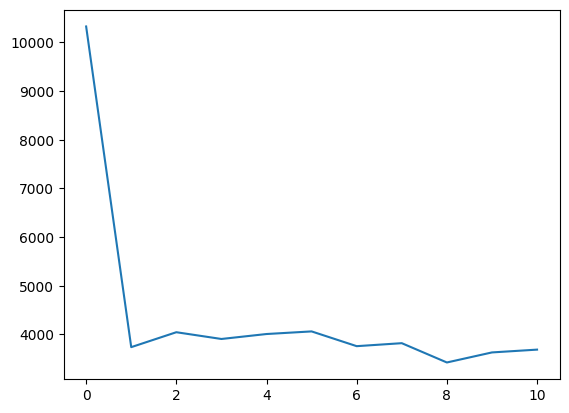

In [78]:
plt.plot(range(len(scores_range)), scores_range)

In [80]:
rf_hat = train_rf(b_hat, n_features, X_train, y_train)
rf_train_results = rf_results(rf_hat, X_train.to_numpy(), y_train.to_numpy())
rf_test_results = rf_results(rf_hat, X_test.to_numpy(), y_test.to_numpy())
print(rf_train_results)
print(rf_test_results)

(1212.5579209940215, 0.8170350825171817)
(3149.32638071081, 0.5229808244195386)


In [58]:
def importance(rf, X):
    """
    Calculate the importance of each feature in the random forest.
    Args:
        rf: A trained random forest through train_rf function.
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): the importance of each feature, of shape (p,).
    """
    return np.array([np.mean([tree['feature_index'] for tree in rf]) for x in X])

In [62]:
def loss_split_bag(X, y):
    """
    Choose the best feature to split according to criterion.
    Args:
        X: training features, of shape (N, p).
        y: vector of training labels, of shape (N,).
    Returns:
        (float, int, float): the minimized loss value.
    """
    min_loss_val, split_column, split_val = np.inf, 0, 0

    for column in range(12):
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue

        # search for the best splitting value for the given column.
        loss_val, val = loss_split_value(X, y, column)
        if loss_val < min_loss_val:
            min_loss_val, split_column, split_val = loss_val, column, val

    return min_loss_val, split_column, split_val

In [63]:
def build_tree_bag(X, y, feature_names, depth,  max_depth=10, min_samples_leaf=10):
    """Build the decision tree according to the data.
    Args:
        X: (np.array) training features, of shape (N, p).
        y: (np.array) vector of training labels, of shape (N,).
        feature_names (list): record the name of features in X in the original dataset.
        depth (int): current depth for this node.
    Returns:
        (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
          1. 'feature_name': The column name of the split.
          2. 'feature_index': The column index of the split.
          3. 'value': The value used for the split.
          4. 'categorical': indicator for categorical/numerical variables.
          5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
          6. 'left': The left sub-tree with the same structure.
          7. 'right' The right sub-tree with the same structure.
    """
    # include a clause for the cases where (i) all lables are the same, (ii) depth exceed (iii) X is too small
    if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf:
        return {'mean_value': np.mean(y)}

    else:
        loss, split_column, split_val = loss_split_bag(X, y)

        # If loss is infinity, it means that samples are not seperable by the sampled features.
        if loss == np.inf:
            return {'mean_value': np.mean(y)}
        (X_l, y_l), (X_r, y_r) = split_samples(X, y, split_column, split_val)
        return {
            'feature_name': feature_names[split_column],
            'feature_index': split_column,
            'value': split_val,
            'mean_value': None,
            'left': build_tree_bag(X_l, y_l, feature_names, depth + 1, max_depth, min_samples_leaf),
            'right': build_tree_bag(X_r, y_r, feature_names, depth + 1, max_depth, min_samples_leaf)
        }

In [64]:
def train_bag(B, X, y):
    """
    Build the decision tree according to the training data.
    Args:
        B: number of decision trees.
        X: (pd.Dataframe) training features, of shape (N, p). Each X[i] is a training sample.
        y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
        an integer in the range 0 <= y[i] <= C. Here C = 1.
    """
    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []

    for _ in range(B):
        # Sample the training_indices (with replacement)
        sample = np.random.choice(training_indices, N, replace=True) 

        X_sample = X[sample, :]
        y_sample = y[sample]
        tree = build_tree_bag(X_sample, y_sample, feature_names, depth=1)
        trees.append(tree)

    return trees

In [73]:
def predict_bag(rf, X):
    """
    Predict classification results for X.
    Args:
        rf: A trained random forest through train_rf function.
        X: (pd.Dataframe) testing sample features, of shape (N, p).
    Returns:
        (np.array): predicted testing sample labels, of shape (N,).
    """

    if len(X.shape) == 1:
        # if we have one sample
        return np.mean([find(tree, X) for tree in rf])
    else:
        # if we have multiple samples
        return np.array([np.mean([find(tree, x) for tree in rf]) for x in X])

In [74]:
def bag_results(rf, X, y):
    """
    Return the R^2 and MSE score of the random forest on the data.
    Args:
        rf: (list) the random forest.
        X: (pd.Dataframe) testing sample features, of shape (N, p).
        y: (pd.Series) vector of testing labels, of shape (N,).
    Returns:
        (float): R^2 score of the rf on the data.
        (float): MSE score of the rf on the data.
    """
    y_pred = predict_bag(rf, X)
    return mse(y, y_pred), rsq(y, y_pred)

In [75]:
rf_bag = train_bag(b_hat, X_train, y_train)

In [81]:
bag_train_results = bag_results(rf_bag, X_train.to_numpy(), y_train.to_numpy())
bag_test_results = bag_results(rf_bag, X_test.to_numpy(), y_test.to_numpy())
print(bag_train_results)
print(bag_test_results)

(1042.4951083022663, 0.8426961482298492)
(2739.0939060083565, 0.5851175270736249)


Text(0.5, 1.0, '$R^2$ for each method')

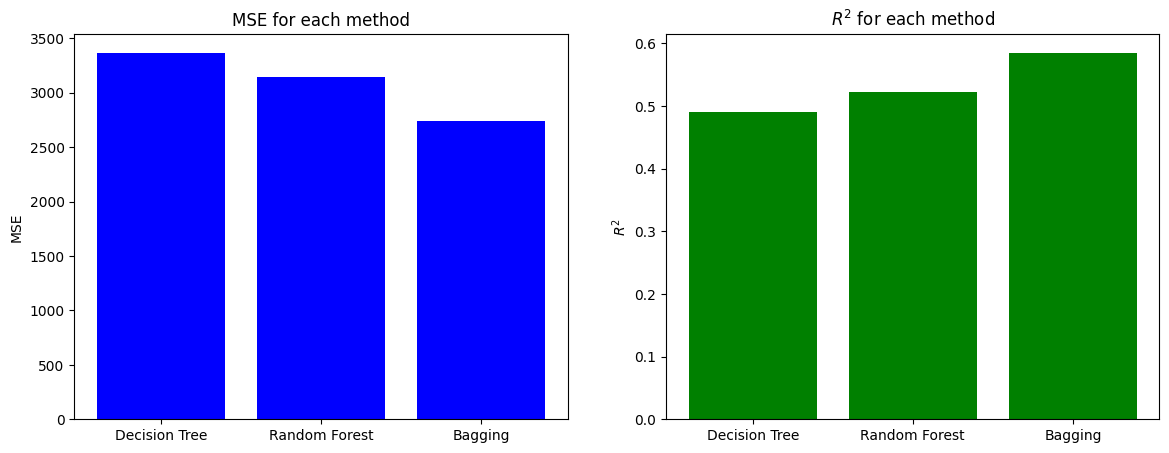

In [93]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

labels = ('Decision Tree', 'Random Forest', 'Bagging')

MSE_vals = [tree_test_results[0], rf_test_results[0], bag_test_results[0]]
rsq_vals = [tree_test_results[1], rf_test_results[1], bag_test_results[1]]

ax[0].bar(labels, MSE_vals, color = 'blue')
ax[0].set_ylabel('MSE')
ax[0].set_title('MSE for each method')

ax[1].bar(labels, rsq_vals, color = 'green')
ax[1].set_ylabel(r'$R^2$')
ax[1].set_title(r'$R^2$ for each method')

<a name="task-113"></a>

### (1.1.3) [(index)](#index-task-113)



---



<a name="task-12"></a>

## (1.2) Multi-layer Perceptron [(index)](#index-task-12)

<a name="task-121"></a>

### (1.2.1) [(index)](#index-task-121)

In [94]:
def standardise(X, X_train_=None):
    """Standardise features.

    Parameters:
        X (np.array): Feature matrix.
        X_train_ (np.array): An optional feature matrix to compute the statistics
            from before applying it to X. If None, just use X to compute the statistics.

    Returns:
        X_std (np.array): Standardised feature matrix
    """
    if X_train_ is None:
        X_train_ = X

    mu = np.mean(X_train_, axis=0, keepdims=True) 
    sigma = np.std(X_train_, axis=0, keepdims=True) 
    X_std = (X - mu) / sigma 
    return X_std

In [98]:
X_train = standardise(X_train)
X_test = standardise(X_test, X_train_=X_train)

In [ ]:
def dense(X, W, b):
    """Full-connected MLP layer.

    Parameters:
        X (np.ndarray): K x h_in array of inputs, where K is the batch size and h_in if the input features dimension.
        W (np.ndarray): h_out x h_in array for kernel matrix parametersm, where h_out is the output dimension.
        b (np.ndarray): Length h_out 1-D array for bias parameters

    Returns:
        a (np.ndarray): K x h_out array of pre-activations
    """
    a = np.vstack([W @ x + b for x in X])
    return a

In [99]:
def activation(a):
    """activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        h: K x h_out array of post-activations
    """
    # compute post-activations
    h = np.arctan(a) * np.log(np.abs(a) + 1)
    return h

## EDIT THIS FUNCTION
def grad_activation(a):
    """Gradient of activation function.

    Parameters:
        a: K x h_out array of pre-activations

    Returns:
        grad: K x h_out gradient array of post-activations
    """
    # compute gradient
    grad = np.log(np.abs(a) + 1) / (1 + a ** 2) + (np.arctan(a) * np.sign(a)) / (np.abs(a) + 1)
    return grad

Our MLP will need the following parameters:

Input layer -> first hidden layer:
* Kernel $\boldsymbol{W}^{(0)} \in\mathbb{R}^{50 \times 12}$
* Bias $\boldsymbol{b}^{(0)} \in\mathbb{R}^{50}$

Hidden layer -> hidden layer:
* Kernel $\boldsymbol{W}^{(k)} \in\mathbb{R}^{50\times 50}$, $k=1, 2$
* Bias $\boldsymbol{b}^{(k)} \in\mathbb{R}^{50}$, $k=1, 2$

Hidden layer -> output layer:
* Kernel $\boldsymbol{W}^{(3)} \in\mathbb{R}^{1 \times 50}$
* Bias $\boldsymbol{b}^{(3)} \in\mathbb{R}^{1}$

We will create these parameters as numpy arrays, and initialise the kernel values with samples from a zero-mean Gaussian distribution with variance $2 / (n_{in} + n_{out})$, where $n_{in}$ and $n_{out}$ are the number of neurons going in and out of the dense layer respectively. This initialisation strategy is known as [Glorot initialisation](http://proceedings.mlr.press/v9/glorot10a.html). The bias parameters will be initialised to zeros.

<a name="task-122"></a>

### (1.2.2) [(index)](#index-task-122)

<a name="task-123"></a>

### (1.2.3) [(index)](#index-task-123)



---



<a name="task-2"></a>

# (2) Task 2: Classification [(index)](#index-task-2)

<a name="task-21"></a>

## (2.1) k-Nearest Neighbours [(index)](#index-task-21)

<a name="task-211"></a>

### (2.1.1) [(index)](#index-task-211)

<a name="task-212"></a>

### (2.1.2) [(index)](#index-task-212)

<a name="task-213"></a>

### (2.1.3) [(index)](#index-task-213)

<a name="task-214"></a>

### (2.1.4) [(index)](#index-task-214)



---



<a name="task-22"></a>

## (2.2) Logistic regression vs kernel logistic regression [(index)](#index-task-22)

<a name="task-221"></a>

### (2.2.1) [(index)](#index-task-221)

<a name="task-222"></a>

### (2.2.2) [(index)](#index-task-222)

<a name="task-223"></a>

### (2.2.3) [(index)](#index-task-223)